![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas_profiling

import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
%matplotlib inline
import seaborn as sns 

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor 
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import re

from datetime import datetime, timedelta
import time

# Any results you write to the current directory are saved as output.

import plotly
import plotly.express as px
import plotly.graph_objects as go
import cufflinks as cf
import plotly.offline as pyo
from plotly.offline import init_notebook_mode,plot,iplot

import folium

pyo.init_notebook_mode(connected=True)
cf.go_offline()

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [4]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [6]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [8]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [9]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [10]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [11]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Как мы видим, в анализируемом наборе данных пропущенные значения  имеются в столбцах 'Cuisine Stayle', 'Price Range', 'Number of Reviews', 'Reviews'.

Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [13]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
31540,id_9636,Paris,"['French', 'European', 'Vegetarian Friendly', ...",9638.0,$,108.0,"[['Not for our taiste', 'Great crepes and coff...",/Restaurant_Review-g187147-d2720510-Reviews-Cr...,d2720510,1,3.5
39192,id_314,Paris,"['French', 'European', 'Vegetarian Friendly', ...",315.0,$$ - $$$,112.0,"[['A great example of a Parisian restaurant', ...",/Restaurant_Review-g187147-d12128139-Reviews-L...,d12128139,1,4.5
5165,id_5165,Milan,NaN,4448.0,NaN,6.0,"[['Milano Centrale gem'], ['09/16/2014']]",/Restaurant_Review-g187849-d7085681-Reviews-Ba...,d7085681,0,0.0
48430,id_1370,Budapest,NaN,1371.0,NaN,2.0,"[['Best gyro in the neighborhood', 'Excellent ...",/Restaurant_Review-g274887-d10686596-Reviews-A...,d10686596,1,5.0
14812,id_5068,Rome,NaN,5069.0,NaN,25.0,"[['Great food and wonderful staff', 'tasty foo...",/Restaurant_Review-g187791-d8340787-Reviews-Mo...,d8340787,1,4.0


In [14]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

Как указано выше, в анализируемом наборе данных пропущенные значения имеются в столбцах 'Cuisine Stayle', 'Price Range', 'Number of Reviews', 'Reviews'.

In [15]:
# Обработаем столбец 'Cuisine Stayle'
data['Cuisine_Style_isNAN'] = pd.isna(data['Cuisine Style']).astype('uint8')

In [16]:
data['Cuisine_Style_isNAN']

0        0
1        0
2        0
3        0
4        0
        ..
49995    0
49996    0
49997    0
49998    0
49999    0
Name: Cuisine_Style_isNAN, Length: 50000, dtype: uint8

In [17]:
#Заменим пропуски в 'Cuisine Style' на значение 'Not value'
data['Cuisine Style'].fillna("['Not value']", axis=0, inplace=True)

In [18]:
#Обработаем столбец 'Price Range'
data['Price_Range_isNAN'] = pd.isna(data['Price Range']).astype('uint8')

In [19]:
data['Price_Range_isNAN']

0        0
1        0
2        0
3        0
4        0
        ..
49995    0
49996    0
49997    1
49998    0
49999    0
Name: Price_Range_isNAN, Length: 50000, dtype: uint8

In [20]:
# Заполним пропуски в 'Price Range' на значение 0
data['Price Range'].fillna('0', axis=0, inplace=True)

In [21]:
# Обработаем столбец 'Number of Reviews'
data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')

In [22]:
data['Number_of_Reviews_isNAN']

0        0
1        0
2        0
3        0
4        0
        ..
49995    0
49996    0
49997    0
49998    0
49999    0
Name: Number_of_Reviews_isNAN, Length: 50000, dtype: uint8

In [23]:
# Далее заполняем пропуски значением 0.
data['Number of Reviews'].fillna(0, inplace=True)

In [24]:
# Обработаем столбец 'Reviews'
data['Reviews_isNAN'] = pd.isna(data['Reviews']).astype('uint8')

In [25]:
data['Reviews_isNAN']

0        0
1        0
2        0
3        0
4        0
        ..
49995    0
49996    0
49997    0
49998    0
49999    0
Name: Reviews_isNAN, Length: 50000, dtype: uint8

In [26]:
#Заменим пропуски в 'Reviews' на значение 'Not reviews'
data['Reviews'].fillna("['Not reviews']", axis=0, inplace=True)

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
Restaurant_id              50000 non-null object
City                       50000 non-null object
Cuisine Style              50000 non-null object
Ranking                    50000 non-null float64
Price Range                50000 non-null object
Number of Reviews          50000 non-null float64
Reviews                    50000 non-null object
URL_TA                     50000 non-null object
ID_TA                      50000 non-null object
sample                     50000 non-null int64
Rating                     50000 non-null float64
Cuisine_Style_isNAN        50000 non-null uint8
Price_Range_isNAN          50000 non-null uint8
Number_of_Reviews_isNAN    50000 non-null uint8
Reviews_isNAN              50000 non-null uint8
dtypes: float64(3), int64(1), object(7), uint8(4)
memory usage: 4.4+ MB


### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [28]:
data.nunique(dropna=False)

Restaurant_id              13094
City                          31
Cuisine Style              10732
Ranking                    12975
Price Range                    4
Number of Reviews           1574
Reviews                    41858
URL_TA                     49963
ID_TA                      49963
sample                         2
Rating                        10
Cuisine_Style_isNAN            2
Price_Range_isNAN              2
Number_of_Reviews_isNAN        2
Reviews_isNAN                  2
dtype: int64

Какие признаки можно считать категориальными?

Анализ полученных результатов позволяет предположить, что в анализируемом наборе данных категориальным признаком является признак "City".

Для кодирования категориальных признаков есть множество подходов:
* Label Encoding
* One-Hot Encoding
* Target Encoding
* Hashing

Выбор кодирования зависит от признака и выбраной модели.
Не будем сейчас сильно погружаться в эту тематику, давайте посмотрим лучше пример с One-Hot Encoding:
![](https://i.imgur.com/mtimFxh.png)

## Обработаем признак 'Cuisine Style'.

In [29]:
# Создадим столбец с количеством представленных стилей кухонь в каждом ресторане
data['Cuisine_count'] = data['Cuisine Style'].str[2:-2].str.split("', '").str.len()

In [30]:
data['Cuisine_count']

0        2
1        5
2        1
3        5
4        6
        ..
49995    4
49996    5
49997    2
49998    5
49999    1
Name: Cuisine_count, Length: 50000, dtype: int64

In [31]:
data['Cuisine_count'].describe()

count    50000.000000
mean         2.625320
std          1.824029
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         21.000000
Name: Cuisine_count, dtype: float64

In [32]:
#Посмотрим расределение признака 'Ranking'(ранг ресторанов) и признака 'Number of Reviews' 
#(количество отзывов) в зависимости от количества кухонь, представленных в ресторане.
data.pivot_table(values = ['Ranking', 'Number of Reviews'], 
               index = 'Cuisine_count', 
               aggfunc = 'mean').iplot(kind = 'bar', title = 'Ранг ресторанов и отзывы в зависимости от количества кухонь')

Полученная визуализация показывает распределение признака 'Ranking' (рейтинг ресторана) и признака 'Number of Reviews' (количество отзывов) в зависимости от количесва кухонь, представленных в ресторане.
В целом, чем меньше кухонь, представленных в ресторане, тем выше средний рейтинг и меньше среднее количество отзывов этого ресторана.

## Обработаем признак 'Ranking'

In [33]:
data['Ranking'].describe()

count    50000.000000
mean      3664.427520
std       3700.092452
min          1.000000
25%        972.000000
50%       2278.000000
75%       5241.000000
max      16444.000000
Name: Ranking, dtype: float64

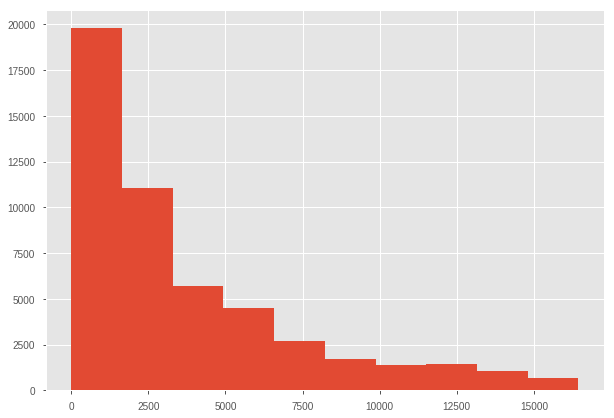

In [34]:
#Посмотрим на распределение признака
plt.rcParams['figure.figsize'] = (10,7)
data['Ranking'].hist()

## Обработаем признак 'Price Range'

In [35]:
data['Price Range'].value_counts()

$$ - $$$    23041
0           17361
$            7816
$$$$         1782
Name: Price Range, dtype: int64

По описанию 'Price Range' это - Цены в ресторане.  
Их можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами, например 1,2,3  
*Попробуйте сделать обработку этого признака уже самостоятельно!*

In [36]:
# Преобразуем значения признака 'Price Range' в числовой формат
data['Price Range'] = data['Price Range'].map({'$$ - $$$': 2, '$': 1, '$$$$':3, '0':0})

In [37]:
data['Price Range'].value_counts()

2    23041
0    17361
1     7816
3     1782
Name: Price Range, dtype: int64

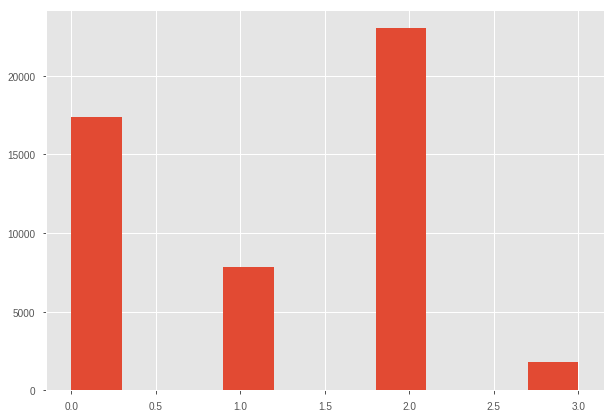

In [38]:
# Посмотрим на распределение признака
plt.rcParams['figure.figsize'] = (10,7)
data['Price Range'].hist()

In [39]:
data.pivot_table(values = ['Price Range'], 
               index = 'City', 
               aggfunc = 'mean').iplot(kind = 'bar', title='Уровень цен по ресторанам')

## Обработка признака 'Reviews'.

In [40]:
#Выделим значения дат отзывов в отдельный столбец 'Data Reviews'
data['Data Reviews'] = data['Reviews'].apply(lambda x: re.findall(r'\d{2}/\d{2}/\d{4}', x))

In [41]:
#Преобразуем строки, содержащие сведения о датах отзывов в список со значениями в формате datetime
for i in range(len(data['Data Reviews'])):
    data['Data Reviews'][i] = [datetime.strptime(x, '%m/%d/%Y') for x in data['Data Reviews'][i]]

In [42]:
#Для удобства вычисления преобразуем даты в другой формат 
for i in range(len(data['Data Reviews'])):
    data['Data Reviews'][i] = list(map(datetime.timestamp, data['Data Reviews'][i]))

In [43]:
#Добавим признак даты последнего отзыва в новом формате
data['Data last Review'] = data.apply(lambda x: max(x['Data Reviews']) if len(x['Data Reviews']) > 0 else 0, axis=1)

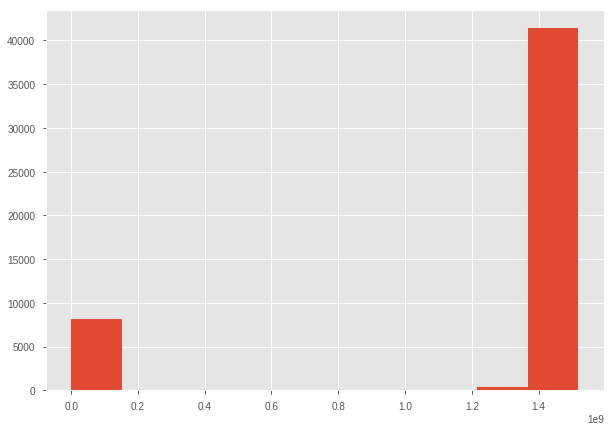

In [44]:
# Посмотрим на распределение нового признака
data['Data last Review'].hist(bins=10)

## Обработка признака 'Number of Reviews'.

In [45]:
data['Number of Reviews'].describe()

count    50000.000000
mean       116.505040
std        286.173104
min          0.000000
25%          7.000000
50%         28.000000
75%        105.000000
max       9660.000000
Name: Number of Reviews, dtype: float64

In [46]:
data.pivot_table(values = ['Number of Reviews'], 
               index = 'Rating', 
               aggfunc = 'mean').iplot(kind = 'bar', title='Распределение ранга от количества отзывов')

In [47]:
#Посмотрим на распределение признака 'Reviews' по городам
data_tmp = data.groupby(['City'])['Number of Reviews'].sum().sort_values(ascending=False)
data_tmp

City
London        933770.0
Rome          728235.0
Paris         680827.0
Milan         431350.0
Barcelona     429437.0
Madrid        357185.0
Prague        199875.0
Lisbon        196347.0
Amsterdam     193814.0
Edinburgh     172103.0
Berlin        155923.0
Budapest      148366.0
Dublin        122804.0
Brussels      113956.0
Vienna        106709.0
Lyon           93952.0
Munich         82386.0
Oporto         80355.0
Copenhagen     73670.0
Stockholm      71588.0
Athens         67765.0
Krakow         67635.0
Warsaw         55636.0
Hamburg        48853.0
Zurich         46769.0
Oslo           46602.0
Geneva         34071.0
Helsinki       29511.0
Luxembourg     20817.0
Ljubljana      18269.0
Bratislava     16672.0
Name: Number of Reviews, dtype: float64

In [48]:
#Создадим признак "Reviews_in_city" - количество отзывов о ресторанах в городе:
data['Reviews_in_city'] = data['City'].apply(lambda x: data_tmp[x])

In [49]:
#Создадим признак 'Relative_ranking_reviews' - ранг ресторана относительно количества отзывов о ресторанах в городе:
data['Relative_ranking_reviews'] = data['Ranking'] / data['Reviews_in_city']


## Обработаем признак 'City'

In [50]:
# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
data = pd.get_dummies(data, columns=[ 'City',], dummy_na=True)

In [51]:
data.head(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
0,id_0,"['Bar', 'Pub']",12963.0,2,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,0,0,1,0,0,0,0,0,0,0
1,id_1,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,2,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,id_2,['Vegetarian Friendly'],810.0,2,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,id_3,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,3,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,id_4,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,3,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
data.sample(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
14290,id_2838,"['Italian', 'Mediterranean']",2839.0,2,128.0,"[['Fantastic authentic Italian', 'Mediocre'], ...",/Restaurant_Review-g187147-d2666560-Reviews-Pa...,d2666560,1,4.0,...,0,0,1,0,0,0,0,0,0,0
28734,id_5561,"['French', 'European', 'Spanish', 'Vegetarian ...",5562.0,2,39.0,"[['Relaxed Cocktail Bar', '""In the Middle Some...",/Restaurant_Review-g187147-d6155926-Reviews-Ar...,d6155926,1,4.0,...,0,0,1,0,0,0,0,0,0,0
22722,id_6120,['German'],6122.0,2,22.0,"[['Very traditional corner', 'Different - but ...",/Restaurant_Review-g187323-d3692276-Reviews-Al...,d3692276,1,3.0,...,0,0,0,0,0,0,0,0,0,0
25952,id_99,"['Swiss', 'Bar', 'European', 'Vegetarian Frien...",100.0,2,242.0,"[['Nice in summer', 'Summer time spacial place...",/Restaurant_Review-g188113-d3607254-Reviews-Fr...,d3607254,1,4.0,...,0,0,0,0,0,0,0,0,1,0
33443,id_5825,"['French', 'American']",5826.0,2,63.0,[['Fantastic location in a beautiful setting.....,/Restaurant_Review-g187147-d5928142-Reviews-DS...,d5928142,1,4.0,...,0,0,1,0,0,0,0,0,0,0


In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 51 columns):
Restaurant_id               50000 non-null object
Cuisine Style               50000 non-null object
Ranking                     50000 non-null float64
Price Range                 50000 non-null int64
Number of Reviews           50000 non-null float64
Reviews                     50000 non-null object
URL_TA                      50000 non-null object
ID_TA                       50000 non-null object
sample                      50000 non-null int64
Rating                      50000 non-null float64
Cuisine_Style_isNAN         50000 non-null uint8
Price_Range_isNAN           50000 non-null uint8
Number_of_Reviews_isNAN     50000 non-null uint8
Reviews_isNAN               50000 non-null uint8
Cuisine_count               50000 non-null int64
Data Reviews                50000 non-null object
Data last Review            50000 non-null float64
Reviews_in_city             50000 non-null f

![](https://cs10.pikabu.ru/post_img/2018/09/06/11/1536261023140110012.jpg)

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

### Посмотрим распределение признака

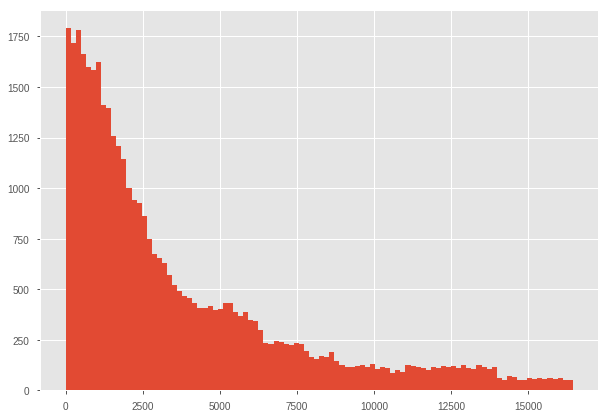

In [54]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

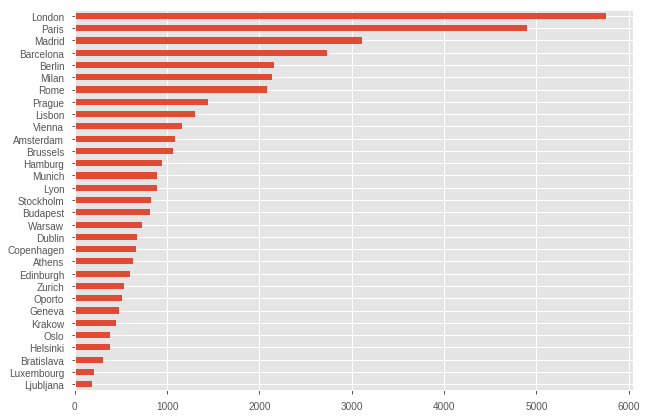

In [55]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

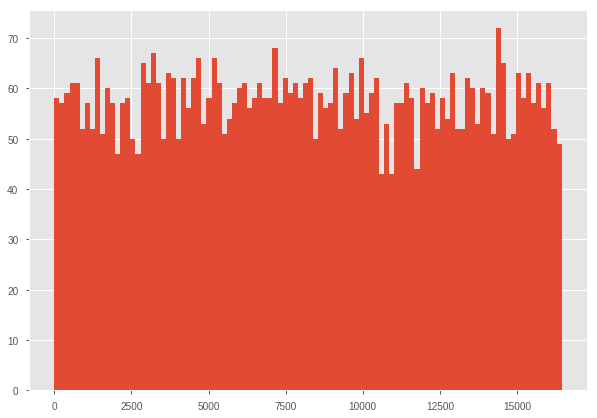

In [56]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

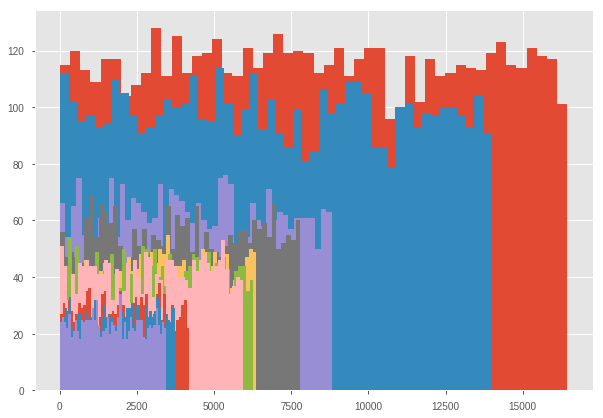

In [57]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=50)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 


### Посмотрим распределение целевой переменной

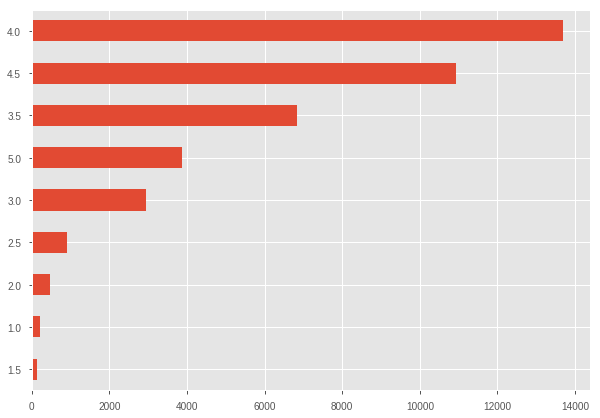

In [58]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

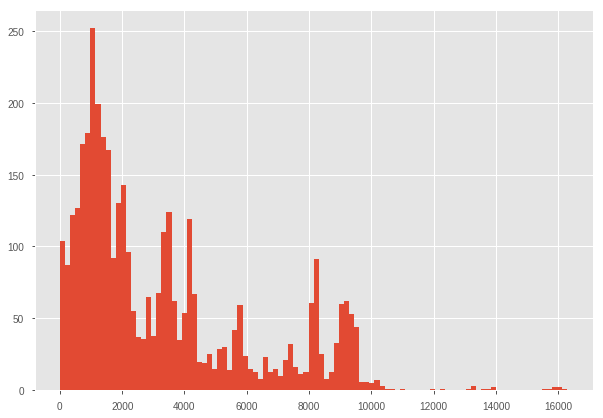

In [59]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

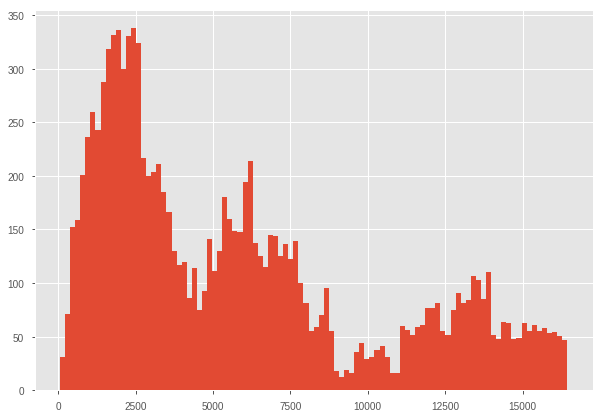

In [60]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

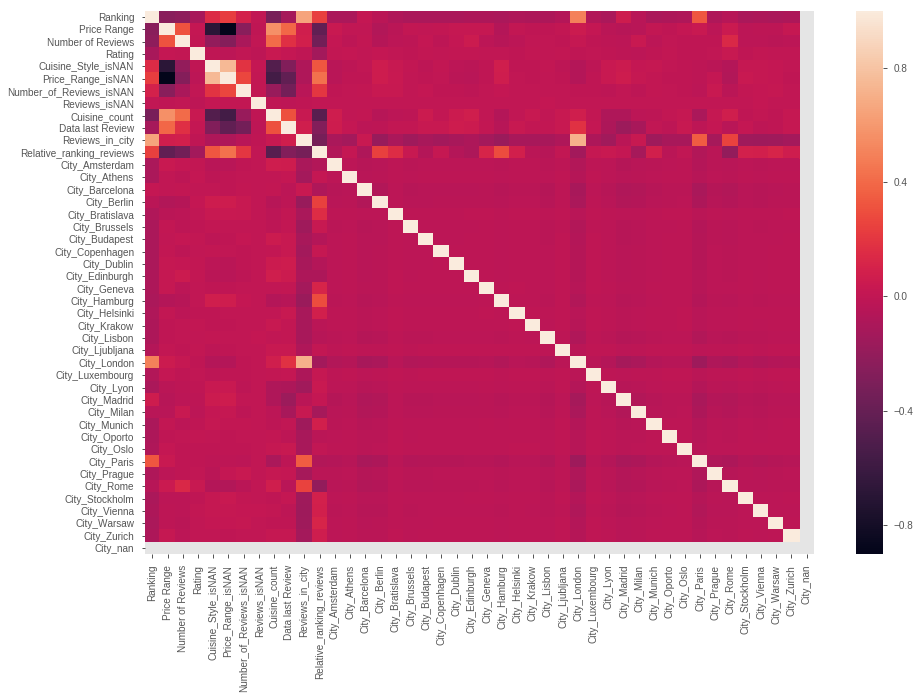

In [61]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 51 columns):
Restaurant_id               50000 non-null object
Cuisine Style               50000 non-null object
Ranking                     50000 non-null float64
Price Range                 50000 non-null int64
Number of Reviews           50000 non-null float64
Reviews                     50000 non-null object
URL_TA                      50000 non-null object
ID_TA                       50000 non-null object
sample                      50000 non-null int64
Rating                      50000 non-null float64
Cuisine_Style_isNAN         50000 non-null uint8
Price_Range_isNAN           50000 non-null uint8
Number_of_Reviews_isNAN     50000 non-null uint8
Reviews_isNAN               50000 non-null uint8
Cuisine_count               50000 non-null int64
Data Reviews                50000 non-null object
Data last Review            50000 non-null float64
Reviews_in_city             50000 non-null f

In [63]:
#Удалим нечисловые признаки:

object_cols = list(data.select_dtypes(include=['object', 'datetime64[ns]', 'timedelta64[ns]']).columns)
data = data.drop(labels=object_cols, axis=1)
data.info()

In [64]:
display(data.describe().head(1))

,Ranking,Price Range,Number of Reviews,sample,Rating,Cuisine_Style_isNAN,Price_Range_isNAN,Number_of_Reviews_isNAN,Reviews_isNAN,Cuisine_count,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
count,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,...,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0


In [65]:
#Разделим датасет на тренировочный и тестовый:
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values
X = train_data.drop(['Rating'], axis=1)

In [66]:
##Воспользуемся специальной функцией train_test_split для разбивки тестовых данных
#выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [67]:
#Проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 45), (40000, 45), (40000, 44), (32000, 44), (8000, 44))

# Model 
Сам ML

In [68]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [69]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [72]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train,y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

ValueError: setting an array element with a sequence.

In [ ]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

In [ ]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [ ]:
test_data.sample(10)

In [ ]:
test_data = test_data.drop(['Rating'], axis=1)

In [ ]:
sample_submission

In [ ]:
predict_submission = model.predict(test_data)

In [ ]:
predict_submission

In [ ]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
